In [1]:
# Clipped and compressed DEM (less computation)

from pysheds.grid import Grid

# PARAMETER - input DEM
# Note, whatever CRS the tif is in will influence the units
# Scalgo7 is NAD 1983 UTM Zone 17N - EPSG:26917
# Scalgo7P is NAD 1983 HARN Florida GDL Albers (Meters) - EPSG:3087
grid = Grid.from_raster(r'data-inputs\\Scalgo7P.tif')
grid_clip = Grid.from_raster(r'data-inputs\\Scalgo7P.tif') # to be clipped by the delineation extent to preserve the original grid
dem = grid.read_raster(r'data-inputs\\Scalgo7P.tif')

In [2]:
import rasterio

# Confirm CRS
# Open the raster file
with rasterio.open(r'data-inputs\\Scalgo7P.tif') as src:
    dem_crs = src.crs
    print(dem_crs)


EPSG:3087


In [8]:
# Confirm area units check out (square meters)
import rasterio
import numpy as np

# Open the raster file
with rasterio.open(r'data-inputs\\Scalgo7P.tif') as src:
    # Read the data
    data = src.read(1)
    
    # Get the pixel size (resolution)
    pixel_width, pixel_height = src.res
    pixel_size = pixel_width * pixel_height
    
    # Calculate the number of valid (non-NaN) pixels
    valid_pixels = np.count_nonzero(~np.isnan(data))
    
    # Calculate the total area
    total_area = valid_pixels * pixel_size
    
    print(f'Total area: {total_area} square meters')
    print(f'Total area: {total_area/4046.85642} acres')



Total area: 68739331.37985337 square meters
Total area: 16985.85871249007 acres


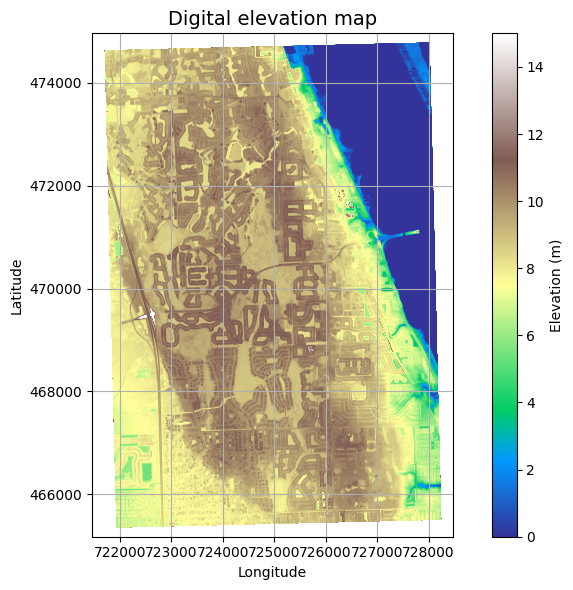

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Define the normalization for the elevation between 0 and 15 meters
norm = colors.Normalize(vmin=0, vmax=15)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

# Plot the DEM with normalization applied
plt.imshow(dem, extent=grid.extent, cmap='terrain', norm=norm, zorder=1)
#plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [5]:
# condition the DEM
pit_filled_dem = grid.fill_pits(dem)

flooded_dem = grid.fill_depressions(pit_filled_dem)
    

inflated_dem = grid.resolve_flats(flooded_dem)

print(inflated_dem.dtype)


dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# if 'nodata' error (numpy issue)  
# fdir = grid.flowdir(inflated_dem, dirmap=dirmap, nodata_out=np.int64(0))

fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

float64


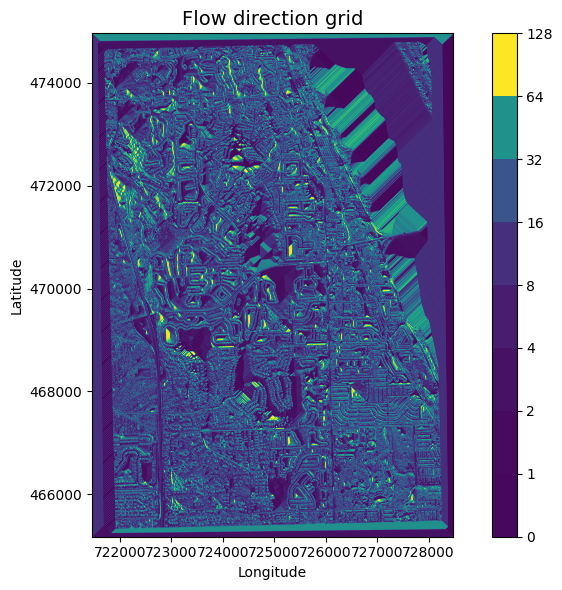

In [6]:
#unproj dem
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

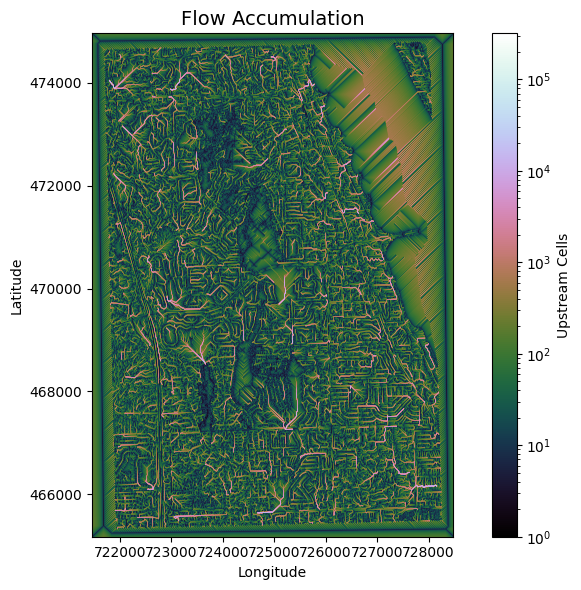

In [7]:
# Calculate and plot flow accumulation

#unproj dem
acc = grid.accumulation(fdir, dirmap=dirmap)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
# ponds.plot()
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

<built-in method max of Raster object at 0x0000018B31953640>


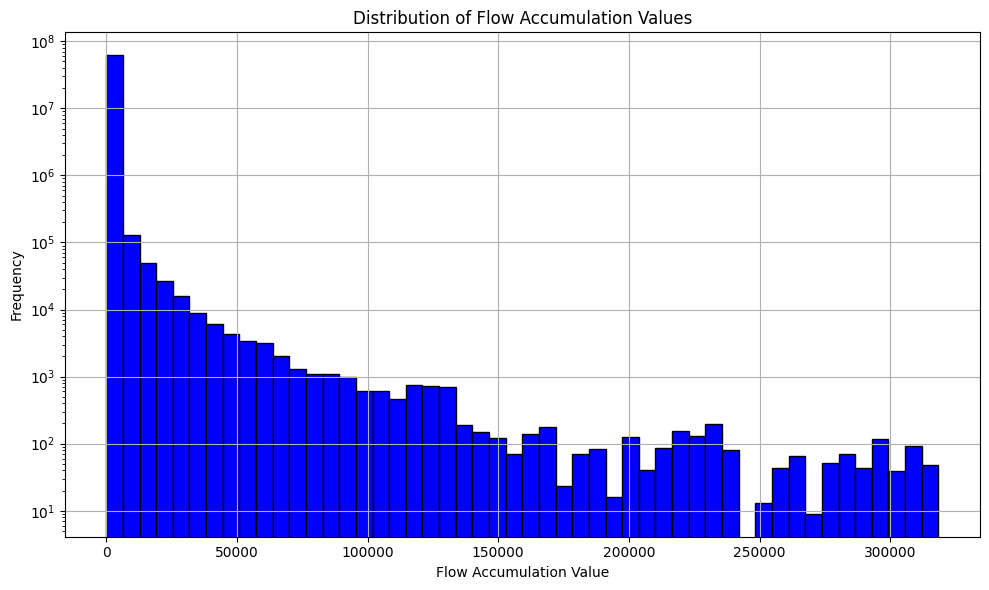

In [48]:
# Plot the distribution of flow accumulation

import matplotlib.pyplot as plt

# Assuming 'acc' is the flow accumulation raster array
# Flatten the array to get all values
acc_values = acc.flatten()

# Plot the distribution of the flow accumulation values
plt.figure(figsize=(10, 6))
plt.hist(acc_values, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Flow Accumulation Values')
plt.xlabel('Flow Accumulation Value')
plt.ylabel('Frequency')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# OPTIMIZATION - find catchment with largest area based on min flow acc values

import geopandas as gpd
from shapely import geometry

# Scalgo7P point
pour_point_x, pour_point_y = 726500, 472500

# Flatten the array to get all values
acc_values = acc.flatten()

# Define the function to calculate catchment area for a given flow accumulation threshold
def calculate_catchment_area(flow_acc_threshold):
    try:
        x_snap, y_snap = grid.snap_to_mask(acc > flow_acc_threshold, (pour_point_x, pour_point_y))
        catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
        grid_clip.clip_to(catch)
        catchment_shapes = grid_clip.polygonize()
        catchment_gdf = gpd.GeoDataFrame(geometry=[geometry.shape(shape) for shape, value in catchment_shapes])
        catchment_gdf.set_crs(epsg=3087, inplace=True)
        catchment_gdf['Area_Acres'] = catchment_gdf['geometry'].area / 4046.85642
        return catchment_gdf['Area_Acres'].max()
    except Exception as e:
        return 0

# Iterate over possible values of min flow acc in increments of 5,000
flow_acc_thresholds = range(0, int(acc_values.max()), 5000)
largest_area = 0
best_threshold = 0

for threshold in flow_acc_thresholds:
    area = calculate_catchment_area(threshold)
    if area > largest_area:
        largest_area = area
        best_threshold = threshold

print(f"The largest catchment area is {largest_area} acres with a minimum flow accumulation threshold of {best_threshold}.")


The largest catchment area is 86.12645813628299 acres with a minimum flow accumulation threshold of 315000.


In [55]:
import geopandas as gpd
from shapely import geometry
import numpy as np

# Function to calculate catchment area for a given flow accumulation threshold and pour point
def calculate_catchment_area(flow_acc_threshold, pour_point_x, pour_point_y):
    try:
        x_snap, y_snap = grid.snap_to_mask(acc > flow_acc_threshold, (pour_point_x, pour_point_y))
        catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
        grid_clip.clip_to(catch)
        clipped_catch = grid_clip.view(catch)
        catchment_shapes = grid_clip.polygonize()
        catchment_gdf = gpd.GeoDataFrame(geometry=[geometry.shape(shape) for shape, value in catchment_shapes])
        catchment_gdf.set_crs(epsg=3087, inplace=True)
        catchment_gdf['Area_Acres'] = catchment_gdf['geometry'].area / 4046.85642
        return catchment_gdf['Area_Acres'].max()
    except Exception as e:
        return 0

# Get the bounds of the DEM
xmin, xmax, ymin, ymax = grid_clip.bbox[0], grid_clip.bbox[2], grid_clip.bbox[1], grid_clip.bbox[3]

# Generate 20 random pour points within the bounds
np.random.seed(42)  # For reproducibility
pour_points_x = np.random.uniform(xmin, xmax, 20)
pour_points_y = np.random.uniform(ymin, ymax, 20)

# Iterate over each pour point and find the largest catchment area for each
results = []

for pour_point_x, pour_point_y in zip(pour_points_x, pour_points_y):
    largest_area = 0
    best_threshold = 0
    flow_acc_thresholds = range(0, int(acc_values.max()), 5000)
    
    for threshold in flow_acc_thresholds:
        area = calculate_catchment_area(threshold, pour_point_x, pour_point_y)
        if area > largest_area:
            largest_area = area
            best_threshold = threshold
    
    results.append((pour_point_x, pour_point_y, largest_area, best_threshold))

# Print the results
for i, (px, py, area, threshold) in enumerate(results):
    print(f"Pour Point {i+1}: ({px}, {py}) - Largest Area: {area} acres with Threshold: {threshold}")


Pour Point 1: (727527.3820825934, 466261.965432368) - Largest Area: 86.12645813628299 acres with Threshold: 315000
Pour Point 2: (728076.7546507876, 465851.8466867383) - Largest Area: 87.01612368450157 acres with Threshold: 310000
Pour Point 3: (727868.2083968775, 465984.3834757705) - Largest Area: 86.12645813628299 acres with Threshold: 315000
Pour Point 4: (727741.075241033, 466048.82145752397) - Largest Area: 86.12645813628299 acres with Threshold: 315000
Pour Point 5: (727319.0254633828, 466126.7092241899) - Largest Area: 86.12645813628299 acres with Threshold: 315000
Pour Point 6: (727319.0024652601, 466412.4506217357) - Largest Area: 86.12645813628299 acres with Threshold: 315000
Pour Point 7: (727225.6460320224, 465904.0970135873) - Largest Area: 86.12645813628299 acres with Threshold: 315000
Pour Point 8: (727996.1489113758, 466177.20965135394) - Largest Area: 86.12645813628299 acres with Threshold: 315000
Pour Point 9: (727743.4174994611, 466245.0883934125) - Largest Area: 86.

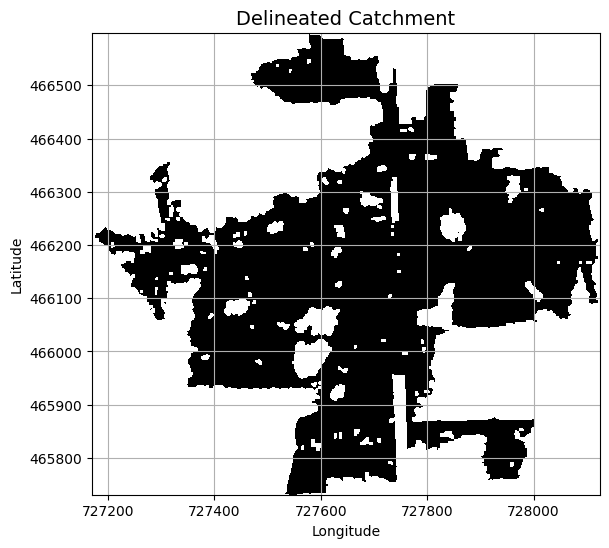

In [50]:
# Delineate the catchment

# PARAMETER - pour point
# Joe's point - USGS tif
# x, y = 534750, 3.114

#x, y = 534000, 3.117

# Scalgo7 point
# pour_point_x, pour_point_y = 533300, 3.121

# Scalgo7P point
pour_point_x, pour_point_y = 726500, 472500

# PARAMETER - minimum flow accumulation
delineation_min_flow_acc = 315000
x_snap, y_snap = grid.snap_to_mask(acc > delineation_min_flow_acc, (pour_point_x, pour_point_y)) #250000

catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')


grid_clip.clip_to(catch)
clipped_catch = grid_clip.view(catch)
# print(grid_clip)

# Convert catchment raster to vector geometry to calculate area
catchment_shapes = grid_clip.polygonize()
catchment_gdf = gpd.GeoDataFrame(geometry=[geometry.shape(shape) for shape, value in catchment_shapes])
catchment_gdf.set_crs(epsg=3087, inplace=True)
catchment_gdf['Area_Acres'] = catchment_gdf['geometry'].area/4046.85642
print(catchment_gdf['Area_Acres'].max)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid_clip.extent,
               zorder=1, cmap='Greys_r', aspect='equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
plt.show()


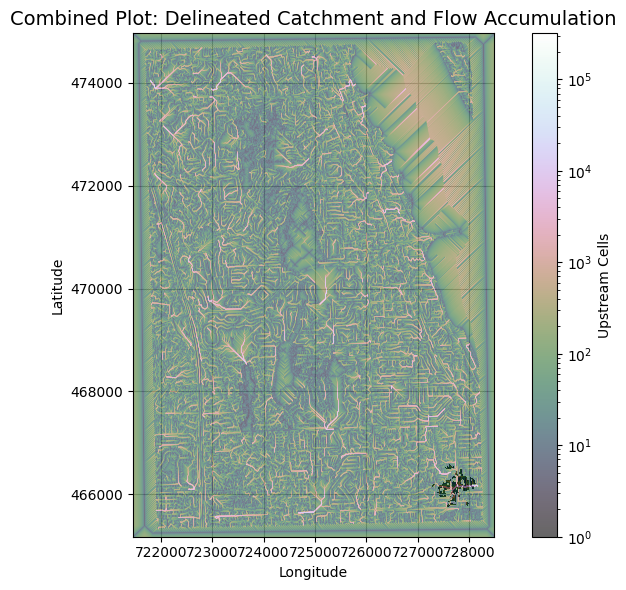

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

# Assuming clipped_catch, grid_clip, acc, and grid are already defined

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

# First plot
plt.grid('on', zorder=0)
im1 = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid_clip.extent,
                zorder=1, cmap='Greys_r', aspect='equal')

# Second plot with transparency
im2 = ax.imshow(acc, extent=grid.extent, zorder=2,
                cmap='cubehelix',
                norm=colors.LogNorm(1, acc.max()),
                interpolation='bilinear', alpha=0.6)

# Add colorbar for the second plot
plt.colorbar(im2, ax=ax, label='Upstream Cells')

plt.title('Combined Plot: Delineated Catchment and Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

plt.show()


<bound method NDFrame._add_numeric_operations.<locals>.max of 0     0.000273
1     0.000273
2     0.000273
3     0.000273
4     0.000273
5    86.126458
Name: Area_Acres, dtype: float64>


<Axes: >

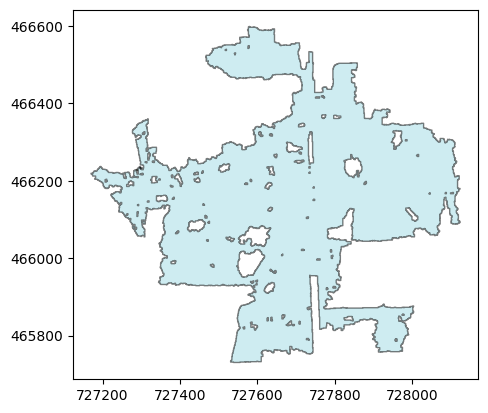

In [52]:
# (If needed)
import geopandas as gpd
from shapely import geometry, ops
# Convert catchment raster to vector geometry
catchment_shapes = grid_clip.polygonize()
catchment_gdf = gpd.GeoDataFrame(geometry=[geometry.shape(shape) for shape, value in catchment_shapes])
catchment_gdf.set_crs(epsg=3087, inplace=True)
catchment_gdf['Area_Acres'] = catchment_gdf['geometry'].area/4046.85642

print(catchment_gdf['Area_Acres'].max)

fig, ax = plt.subplots()
catchment_gdf.plot(ax=ax, aspect=1, cmap='tab20', edgecolor='black', alpha=0.5)

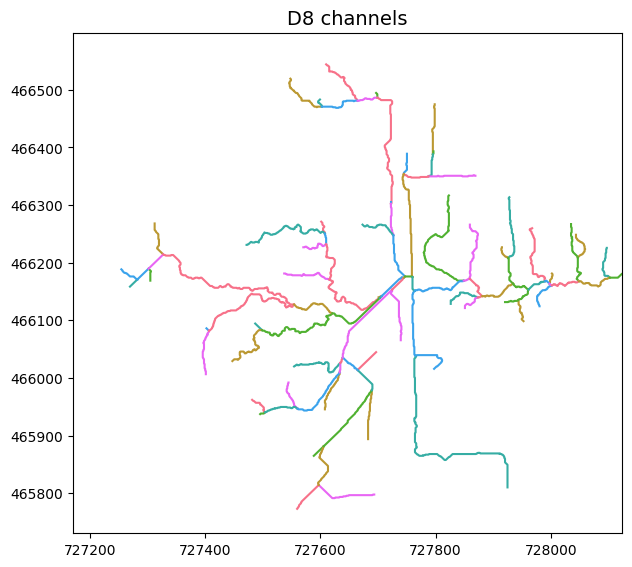

In [53]:
# Find river network branches

# PARAMETER - river_network_min_flow_acc
river_network_min_flow_acc = 2000
# unprojected DEM
branches = grid_clip.extract_river_network(fdir, acc > river_network_min_flow_acc, dirmap=dirmap,  nodata_out=np.int64(0))

sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid_clip.bbox[0], grid_clip.bbox[2])
plt.ylim(grid_clip.bbox[1], grid_clip.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [47]:
# Once happy with delineation, clip grid by catchment
# NOTE: This will alter the original grid so you can't go back and delineate the catchment again without re-running all the above steps
grid.clip_to(catch)

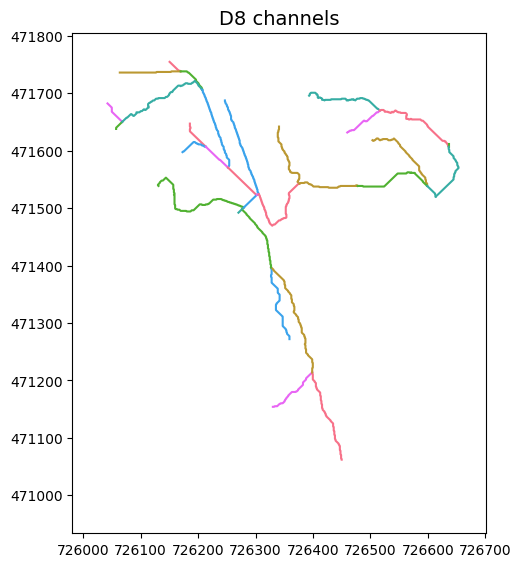

In [49]:
# Find river network branches - with clipped grid

# PARAMETER - river_network_min_flow_acc
river_network_min_flow_acc = 2000
# unprojected DEM
branches = grid.extract_river_network(fdir, acc > river_network_min_flow_acc, dirmap=dirmap,  nodata_out=np.int64(0))

sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [50]:
# Find the junctions in the river network

from collections import defaultdict
import numpy as np


node_counts = defaultdict(int)

precision = 10


for branch in branches['features']:
    
    line = np.asarray(branch['geometry']['coordinates'])
    
    
    for point in line:
       
        rounded_point = tuple(np.round(point, precision))
        node_counts[rounded_point] += 1

junctions = [node for node, count in node_counts.items() if count > 1]

print(f"Junction points: {junctions}")

Junction points: [(726169.695186, 471738.093975), (726207.149643, 471706.051961), (726516.41645, 471669.875494), (726305.601361, 471524.136012), (726068.033087, 471650.23684), (726213.570408, 471606.82508), (726376.229766, 471542.741052), (726252.094993, 471570.648613), (726636.270715, 471606.82508), (726598.816257, 471538.606599), (726613.79804, 471520.001559), (726302.390978, 471523.102399), (726477.891866, 471538.606599), (726279.918304, 471501.396519), (726276.707922, 471498.295678), (726327.003908, 471397.001571), (726398.702441, 471214.052008)]


C:\Users\alden.summerville\AppData\Local\Temp\ipykernel_42596\244910930.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20b', len(junctions))


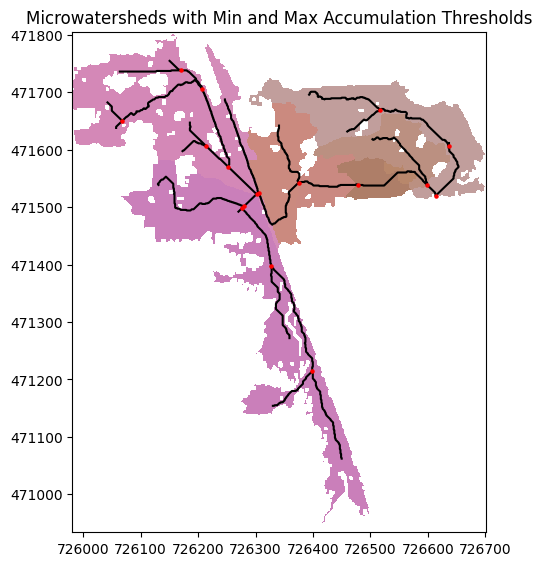

In [61]:
# Delineate MICROWATERSHEDS

#unproj DEM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes

# Create a figure for plotting all catchments
plt.figure(figsize=(8.5, 6.5))

# Set the plot boundaries and aspect ratio
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
plt.gca().set_aspect('equal')

# Define colormap for unique catchment colors
colors = plt.cm.get_cmap('tab20b', len(junctions))

# INPUT PARAMETER: Define the minimum and maximum accumulation thresholds
mws_min_flow_acc = 50000
mws_max_flow_acc = 550000

# Initialize an empty list to store microwatersheds vectors
geometries = []
values = []

# Loop over each junction and plot its catchment
for i, junction in enumerate(junctions):
    x, y = junction
    
    # Snap the junction to the nearest cell where accumulation is between min_acc and max_acc
    mask = (acc > mws_min_flow_acc) & (acc < mws_max_flow_acc)
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    
    # Delineate the catchment for the snapped point
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    # print(type(catch))
    
    # Convert the catchment to vector and add to list (to be transformed into a gdf)
    data = catch.astype(np.float32)
    transform = catch.affine
    mask = data != catch.nodata
    # Extract shapes (vector geometries) from the raster
    shapes_generator = shapes(data, mask=mask, transform=transform)
    # print(shapes_generator)
    # Convert shapes to Shapely geometries
    for geom, value in shapes_generator:
        geometries.append(shape(geom))
        values.append(value)
    
    # Plot the catchment with a unique color
    plt.imshow(np.where(catch, catch, np.nan), extent=grid.extent, cmap=mcolors.ListedColormap([colors(i)]), alpha=0.5)

# Plot the river network on top of the catchments
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], color='black')

# Highlight all junction points
x, y = zip(*junctions)
plt.scatter(x, y, color='red', s=5, zorder=5)

# Create geodataframe of microwatersheds
microwatersheds_gdf = gpd.GeoDataFrame({'geometry': geometries, 'value': values})
microwatersheds_gdf.set_crs(epsg=3087, inplace=True)
# print(microwatersheds_gdf)

# Add title and show the combined plot
plt.title('Microwatersheds with Min and Max Accumulation Thresholds')
plt.show()


C:\Users\alden.summerville\AppData\Local\Temp\ipykernel_42596\1215946809.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(junctions))  # Use a colormap that supports many discrete colors


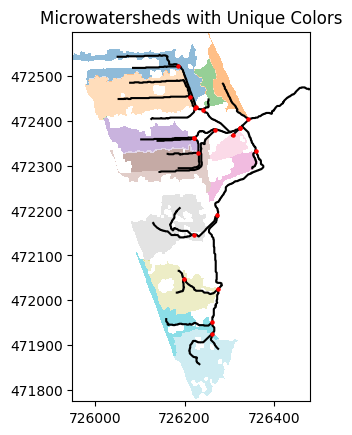

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Set the plot boundaries and aspect ratio
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
plt.gca().set_aspect('equal')

# Define colormap for unique catchment colors
colors = plt.cm.get_cmap('tab20', len(junctions))  # Use a colormap that supports many discrete colors

# Define the minimum and maximum accumulation thresholds
min_acc = 1000
max_acc = 20000

# Create an empty array to store the combined catchment mask
# Use integers to assign a different number for each catchment
combined_catchment = np.zeros(grid.shape, dtype=int)

# Loop over each junction and plot its catchment with a unique color
for i, junction in enumerate(junctions):
    x, y = junction
    
    # Snap the junction to the nearest cell where accumulation is between min_acc and max_acc
    mask = (acc > min_acc) & (acc < max_acc)
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    
    # Delineate the catchment for the snapped point
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    
    # Assign a unique integer value for each catchment
    combined_catchment[catch] = i + 1  # Start numbering catchments from 1
    
# Plot the combined catchments with a unique color for each
# Use a discrete colormap
plt.imshow(np.where(combined_catchment > 0, combined_catchment, np.nan), extent=grid.extent, cmap=colors, alpha=0.5)

# Plot the river network on top of the combined catchments
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], color='black')

# Highlight all junction points
for junction in junctions:
    x, y = junction
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    plt.scatter(x_snap, y_snap, color='red', s=5, zorder=5)

# Add title and show the combined plot
plt.title('Microwatersheds with Unique Colors')
plt.show()


In [62]:
# confirm crs
crs = microwatersheds_gdf.crs
print(crs)

EPSG:3087


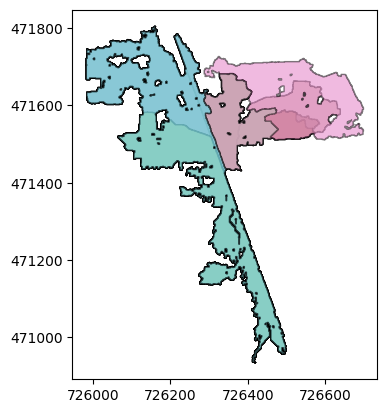

,geometry
0,"POLYGON ((726239.253 471759.8, 726239.253 4717..."
1,"POLYGON ((726181.467 471561.346, 726181.467 47..."
2,"POLYGON ((726182.537 471560.312, 726182.537 47..."
3,"POLYGON ((726684.426 471554.111, 726684.426 47..."
4,"POLYGON ((726240.324 471421.808, 726240.324 47..."
5,"POLYGON ((726270.287 471368.06, 726270.287 471..."
6,"POLYGON ((726157.924 471805.279, 726157.924 47..."
7,"POLYGON ((726416.895 470936.01, 726416.895 470..."
8,"POLYGON ((726417.965 470934.976, 726417.965 47..."


In [63]:
# print(microwatersheds_gdf)
fig, ax = plt.subplots()
microwatersheds_gdf.plot(ax=ax, aspect=1, cmap='tab20', edgecolor='black', alpha=0.5)
plt.show()

# (If needed)
from shapely import geometry, ops
# Convert catchment raster to vector geometry
catchment_shapes = grid.polygonize()
catchment_gdf = gpd.GeoDataFrame(geometry=[geometry.shape(shape) for shape, value in catchment_shapes])
catchment_gdf.set_crs(epsg=26917, inplace=True)
# print(catchment_gdf)


                                              geometry  value  \
0    POLYGON ((726181.467 471561.346, 726181.467 47...    1.0   
1    POLYGON ((726182.537 471560.312, 726182.537 47...    1.0   
2    POLYGON ((726303.461 471524.136, 726303.461 47...    1.0   
3    POLYGON ((726240.324 471421.808, 726240.324 47...    1.0   
4    POLYGON ((726270.287 471368.06, 726270.287 471...    1.0   
..                                                 ...    ...   
109  POLYGON ((726182.537 471560.312, 726182.537 47...    1.0   
110  POLYGON ((726240.324 471421.808, 726240.324 47...    1.0   
111  POLYGON ((726270.287 471368.06, 726270.287 471...    1.0   
112  POLYGON ((726157.924 471804.245, 726157.924 47...    1.0   
113  POLYGON ((726416.895 470936.01, 726416.895 470...    1.0   

     Microwatershed_ID  Area_Acres  
0                    1    0.000273  
1                    2    0.000273  
2                    3    0.000273  
3                    4    0.000273  
4                    5    0.000273

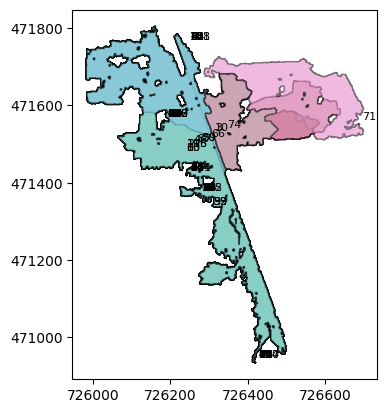

In [64]:
# Calculate areas - tabulate

# Add a simple numeric 'Microwatershed_ID' column starting at 1
microwatersheds_gdf['Microwatershed_ID'] = range(1, len(microwatersheds_gdf) + 1)
# Calculate the area of each polygon in acres (originally in square meters because of the CRS then divide by conversion factor)
microwatersheds_gdf['Area_Acres'] = microwatersheds_gdf['geometry'].area/4046.85642

print(microwatersheds_gdf)


# Create the plot
fig, ax = plt.subplots()
microwatersheds_gdf.plot(ax=ax, aspect=1, cmap='tab20', edgecolor='black', alpha=0.5)

# Add labels
for idx, row in microwatersheds_gdf.iterrows():
    plt.annotate(text=row['Microwatershed_ID'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 xytext=(3, 3), textcoords='offset points', fontsize=8, color='black')

plt.show()


In [65]:
import pandas as pd
import geopandas as gpd
from shapely import geometry, ops

# Load ponds data
ponds = gpd.read_file(r'data-inputs\\IRL-Ponds-Export\\IRL-Ponds-Export.shp')
ponds.to_crs(epsg=3087, inplace=True)

# Calculate the area of each pond
ponds['area'] = ponds.geometry.area/4046.85642

# Find intersecting ponds
ponds_intersect = gpd.sjoin(ponds, microwatersheds_gdf, how='inner', predicate='intersects')

# Count the number of intersecting ponds for each microwatershed
pond_counts = ponds_intersect.groupby('index_right').size().reset_index(name='Pond_Count')

# Sum the area of intersecting ponds for each microwatershed
pond_area_sum = ponds_intersect.groupby('index_right')['area'].sum().reset_index(name='Total_Pond_Area_Acres')

# Combine pond_counts and pond_area_sum into a single DataFrame
pond_summary = pond_counts.merge(pond_area_sum, on='index_right')

# Merge the combined summary DataFrame back into the microwatersheds_gdf
microwatersheds_summary_gdf = microwatersheds_gdf.merge(pond_summary, left_index=True, right_on='index_right', how='left')

# Fill NaN values with 0 (if there are microwatersheds with no intersecting ponds)
microwatersheds_summary_gdf['Pond_Count'] = microwatersheds_summary_gdf['Pond_Count'].fillna(0)
microwatersheds_summary_gdf['Total_Pond_Area_Acres'] = microwatersheds_summary_gdf['Total_Pond_Area_Acres'].fillna(0)

# Select only the specified columns and order by Pond_Count
columns_to_display = ['Microwatershed_ID', 'Area_Acres', 'Pond_Count', 'Total_Pond_Area_Acres']
summary_df = microwatersheds_summary_gdf[columns_to_display].sort_values(by='Pond_Count', ascending=False)

# Print the DataFrame
print(summary_df)


     Microwatershed_ID  Area_Acres  Pond_Count  Total_Pond_Area_Acres
9.0                 87   30.723937         3.0               2.327871
6.0                 66   35.599468         3.0               2.327871
2.0                 20   32.194140         3.0               2.327871
5.0                 59   32.466916         3.0               2.327871
7.0                 74   42.918505         3.0               2.327871
..                 ...         ...         ...                    ...
NaN                 37    0.000273         0.0               0.000000
NaN                 36    0.000273         0.0               0.000000
NaN                 35    0.000273         0.0               0.000000
NaN                 34    0.000273         0.0               0.000000
NaN                114    0.000273         0.0               0.000000

[114 rows x 4 columns]


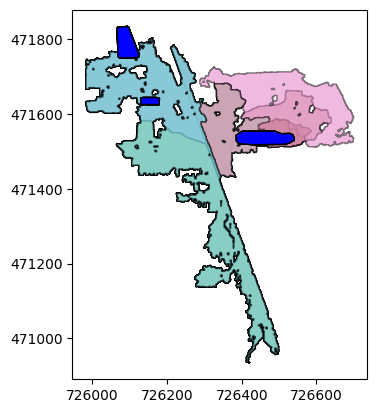

In [66]:
# Print MWS and intersecting ponds

# print(microwatersheds_gdf)
fig, ax = plt.subplots()
microwatersheds_gdf.plot(ax=ax, aspect=1, cmap='tab20', edgecolor='black', alpha=0.5)
ponds_intersect.plot(ax=ax, aspect=1, color='blue', edgecolor='black')
plt.show()

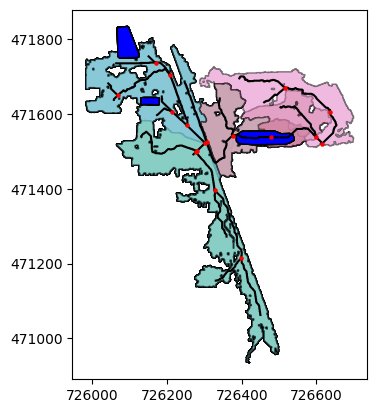

In [67]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Assuming catchment_polygon, ponds_intersect, branches, and junctions are already defined
# Create a GeoDataFrame from the catchment_polygon
# catchment_gdf = gpd.GeoDataFrame(geometry=[catchment_polygon])

# Plot the GeoDataFrame with a fixed aspect ratio
fig, ax = plt.subplots()
microwatersheds_gdf.plot(ax=ax, aspect=1, cmap='tab20', edgecolor='black', alpha=0.5)

# Plot the ponds_intersect on the same plot
ponds_intersect.plot(ax=ax, aspect=1, color='blue', edgecolor='black')

# Plot the river network on top of the catchments
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], color='black')

# Highlight all junction points
x, y = zip(*junctions)
plt.scatter(x, y, color='red', s=5, zorder=5)

plt.show()